# What exactly are "targets" in SoS

* **Difficulty level**: easy
* **Time need to lean**: 10 minutes or less
* **Key points**:
  * Targets are expanded concept from files
  

## Core Targets

Targets are objects that a SoS step can input, output, or dependent on. They are usually files that are presented by filenames, but can also be other targets.

### Target `file_target`

Targets of type `file_target` represents files on a file system. The type ``file_target` should not be used explicitly because SoS treats string type targets as ``file_target`.

SoS uses md5 signature to detect changes of the content of files. To reduce the time to generate signature for large files, SoS extracts strips of data from large files to calculate partial MD5. The resulting signatures are different from md5 signature of complete files calcualted from other tools.

A file can be **zapped** by command `sos remove --zap` and still be considered available by SoS. This command removes a `file` and generates `{file}.zapped` with essential information such as signature and size of the original file. A step would not be rerun if its input, dependent, or output files are zapped instead of removed. This feature is useful for the removal of large intermediate files generated from the execution of workflows, whiling still keeping the complete runtime information of the workflow.

### Target `executable` 

In [49]:
`executable` targets are commands that should be accessible and executable by SoS. These targets are usually listed in the `depends` section of a SoS step. For example, SoS would stop if a command `fastqc` is not found.

%sandbox --expect-error
[10]
input:     'a.txt'
depends:   executable('some_command')
sh: expand=True
    some_command {input}

`executable` target can also be output of a step but installing executables can be tricky because the commands should be installed to existing `$PATH` so that they can be immediately accessible by SoS. Because SoS automatically adds `~/.sos/bin` to `$PATH` (option `-b`), an environment-neutral way for on-the-fly installation is to install commands to this directory. For example

!rm -f ~/.sos/bin/lls

[lls: provides=executable('lls')]
sh:
    echo "#!/usr/bin/env bash" > ~/.sos/bin/lls
    echo "echo I am lls" >> ~/.sos/bin/lls
    chmod +x ~/.sos/bin/lls

[10]
depends: executable('lls')
sh:
    lls

creates an executable command `lls` under `~/.sos/bin` when this executable does not exist.

You can also have finer control over which version of the command is eligible by checking the output of commands. The trick here is to provide a complete command and one or more version strings as the string that should appear in the output of the command.

For example, command `perl --version` is executed in the following example to check if the output contains string `5.18`. The step would only be executed if the right version exists.

[10]
depends: executable('perl --version', version='5.18')
print('ok')

If no verion string is provided, SoS will only check the existence of the command and not actually execute the command.

### Target `sos_variable` 

`sos_variable(name)` targets represent SoS variables that are created by a SoS step and shared to other steps. These targets can be used to provide information to other steps. For example,

In [50]:
%sandbox
[counts: shared='counts']
input: 'result.txt'
with open(input[0]) as ifile:
    counts = int(ifile.read())

[10]

# perform some task and create a file with some statistics
output: 'result.txt'
run:
   echo 100 >> result.txt 

[100]
depends: sos_variable('counts')
report: expand=True
    There are {counts} objects

Step `100` needed some information extracted from output of another step (step `10`). You can either parse the information in step `100` or use another step to provide the information. The latter is recommended because the information could be requested by multiple steps. Note that `counts` is an auxiliary step that provides `sos_variable('counts')` through its `shared` section option.

### Target `env_variable` 

SoS keeps tract of runtime environment and creates signatures of executed steps so that they do not have to be executed again. Some commands, especially shell scripts, could however behave differently with different environmental variables. To make sure a step would be re-executed with changing environments, you should list the variables that affects the output of these commands as dependencies of the step. For example

%sandbox --expect-error
[10]
depends:   env_variable('DEBUG')
sh:
    echo DEBUG is set to $DEBUG

### Target `sos_step` 

The `sos_step` target represents, needless to say, a SoS step. This target provides a straightforward method to specify step dependencies. For example,

In [51]:
%run
[init]
print("Initialize")

[10]
depends: sos_step("init")
print(f"I am {step_name}")

Initialize
I am default_10


What is more interesting, however, is that `sos_step('a')` matches to steps such as `a_1`, `a_2` so the step will depend on the execution of the entire workflow.

For example, in the following workflow, step `default` depends on `sos_step('work')`, which triggers a process-oriented workflow `work` with steps `work_1` and `work_2`.

> test.dot (859 B):

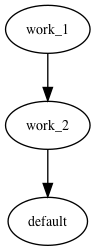

In [5]:
%preview -n test.dot
%run -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
depends: sos_step("work")

This example is similar to the following workflow that uses subworkflow (`sos_run('work')`) but as you can see from the generated DAG, the execution logics of the two are quite different. More specifically, the `sos_step()` target adds a subworkflow to the master DAG, while `sos_run` triggers a separate DAG. 

INFO: work_1 (index=0) is ignored due to saved signature
INFO: work_2 (index=0) is ignored due to saved signature


> test.dot (500 B):

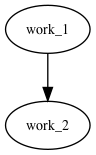

In [6]:
%preview -n test.dot
%run -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
sos_run("work")

### Target `dynamic` 

A `dynamic` target is a target that can only be determined when the step is actually executed. 

For example,

In [52]:
%sandbox --expect-error
[10]
output: '*.txt'
sh:
    touch a.txt

[20]
print(f'Last output is {input}')

To address this problem, you should try to expand the output file after the completion of the step, using a `dynamic` target.

In [53]:
%sandbox
[10]
output: dynamic('*.txt')
sh:
    touch a.txt

[20]
print(f"Last output is {input}")

Please refer to chapter [SoS Step](SoS_Step.html) for details of such targets.

### Target `remote`

A target that is marked as `remote` and would be instantiated only when it is executed by a task. Please check section [Remote Execution](Remote_Execution.html) for details.

### Target `system_resource`

Target `system_resource` checks the available system resource and is available only if the system has enough memory and/or diskspace for the workflow step. For example, the following step would generate an error if the system does not have at least `16G` of RAM and `1T` of disk space on the volume of the current project directory.

In [3]:
%run
[10]
depends: system_resource(mem='16G', disk='1T')
run:
   echo "some large job"

No step to generate target system_resource(mem='16G',disk='1T') requested by default_10


### Target `R_library`

The `R_library` target represents a R library. If the libraries are not available, it will try to install it from [CRAN](https://cran.r-project.org/), [bioconductor](https://www.bioconductor.org/), or [github](https://github.com/). Github package name should be formatted as `pkg@path`. A typical usage of this target would be

In [64]:
%sandbox
[10]
output: 'test.jpg'
depends: R_library('ggplot2')
R: expand=True
  library(ggplot2) 
  jpeg({output!r})
  qplot(Sepal.Length, Petal.Length, data = iris, color = Species)
  dev.off()


`R_library` can also be used to check for specific versions of packages. For example:

```
R_library('edgeR', '3.12.0')
```
will result in a warning if edgeR version is not 3.12.0. You can specify multiple versions 

```
R_library('edgeR', ['3.12.0', '3.12.1'])
```

certain version or newer,
```
R_library('edgeR', '>=3.12.0')
```

certain version or older
```
check_R_library('ggplot2', '<1.0.0')
```

The default R library repo is `http://cran.us.r-project.org`. It is possible to customize the repo for which a R library would be installed, for example:

```
R_library('Rmosek', repos = "http://download.mosek.com/R/7")
```

To install from a github repository:

```
R_library('varbvs@pcarbo/varbvs/varbvs-R')
```
where `varbvs` is package name, `pcarbo/varbvs/varbvs-R` corresponds to sub-directory `varbvs-R` in repository `https://github.com/pcarbo/varbvs`.

### Target `Py_Module`

This target is usually used in the `depends` statement of a SoS step to specify a required Python module. For example,

In [61]:
depends: Py_Module('tabulate')
from tabulate import tabulate
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
    ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table))

-----  ------  -------------
Sun    696000     1.9891e+09
Earth    6371  5973.6
Moon     1737    73.5
Mars     3390   641.85
-----  ------  -------------


If a module is not available, with `autoinstall=True` SoS will try to execute command `pip install` to install it, which might or might not succeed depending on your system configuration. For example,

```
Py_Module('numpy', autoinstall=True)
```

To specify version, 

```
Py_Module('numpy', version=">=1.14.0")
```

Or a shorthand syntax, 

```
Py_Module('numpy>1.14.0')
```

## Further reading

* 